### CS156 Assignment 6: LBA - Dimensionality Reduction, Compression and Reconstruction of Pictures
_Yoav Rabinovich, December 2018_

---------------------------

For this assignment I took 46 pictures of Berlin's Fernsehturm (Television Tower) over the course of 4 hours and ten minutes at an approximate pace of one picture every 5 minutes, from a tripod in a café in Alexanderplatz. I only purchased two cups of coffee and a slice of cake throughout that period, and recieved 14 scornful looks from the staff, and 3 questions about my interest in "anything else?".

The principal component analysis of my pictures shows that two components can explain over 87% of the variation in the data. This doesn't surprise me, since aiming the camera to the sky not many features vary over time. Visualizing the principal components it's clear that they mosty deal with formations of clouds, and their correlation with the lights on the tower tip.

The components in the 2D compressed space follow a gentle curve, with sequential points very close to one another. One component varies almost perfectly linearly with time, which makes sense since prominent features like the color of the sky and the tower lights vary linearly with time. The other variable follows a sinusoidal curve, which requires further investigation. Varying each component individually to reveal the derivative effects on the picture, it becomes clear that the linearly varying component really corresponds to sky color and tower lights. The sinusoidal varying component seems to govern the way the tower is lit from the outside, which is a feautre influenced by the clouds (which could have come and gone in a nice sinusoidal curve) and by the external lighting, which turns on at one point and becomes more visible as the sky darkens.

Overall, reconstructing all pictures, they seem to represent the originals very accurately, with few visual artifacts, and with natural time progression. Points taken far from the curve appear quite normal, sadly. However, points taken outside the bounds of known examples are far more interesting.

I've dedicated a simple cell to emphasize the compression power of PCA and this example specifically. 87% of the variance was explained by 2 dimensions, for data that was previously stored in 512x288x3=442,368 dimensions, with pictures still reconstructed accurately, with the only extra requirement that the PCA component matrix is also stored (and a bit of computing time). The reconstructed pictures are also generally compressed more efficiently by other algorithms (jpg in this case), but I cannot explain why.

In [3]:
# Imports
from os import listdir, stat
from PIL import Image, ImageFile
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

In [2]:
# Loading pictures
# already converted to 512*288 (16:9 ratio)
directory = listdir("Tower")
data = []
for image in directory:
    imagepath = "Tower/" + image
    img = Image.open(imagepath)
    img_arr = np.frombuffer(img.tobytes(), dtype=np.uint8)
    data.append(img_arr)
    img.close()

In [4]:
# Function to reconstruct images from bytes
def reconstruct(array):
    template = np.zeros((288, 512, 3), dtype=np.uint8)
    for j,val in enumerate(array):
        pxl = math.floor(j/3)
        clr = j%3
        row = math.floor(pxl/512)
        col = pxl%512
        template[row][col][clr] = val
    return Image.fromarray(template, 'RGB')

In [10]:
# Function to plot gallery
def plot_gallery(title, images, n_row, n_col, scale, cmap=plt.cm.gray):
    plt.figure(figsize=(16 * scale * n_col, 9 * scale * n_row))
    plt.suptitle(title, size=70*scale)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(comp, cmap=cmap,interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [9]:
# Plot original 
images0=[]
for i in range(46):
    images0.append(reconstruct(data[i]))

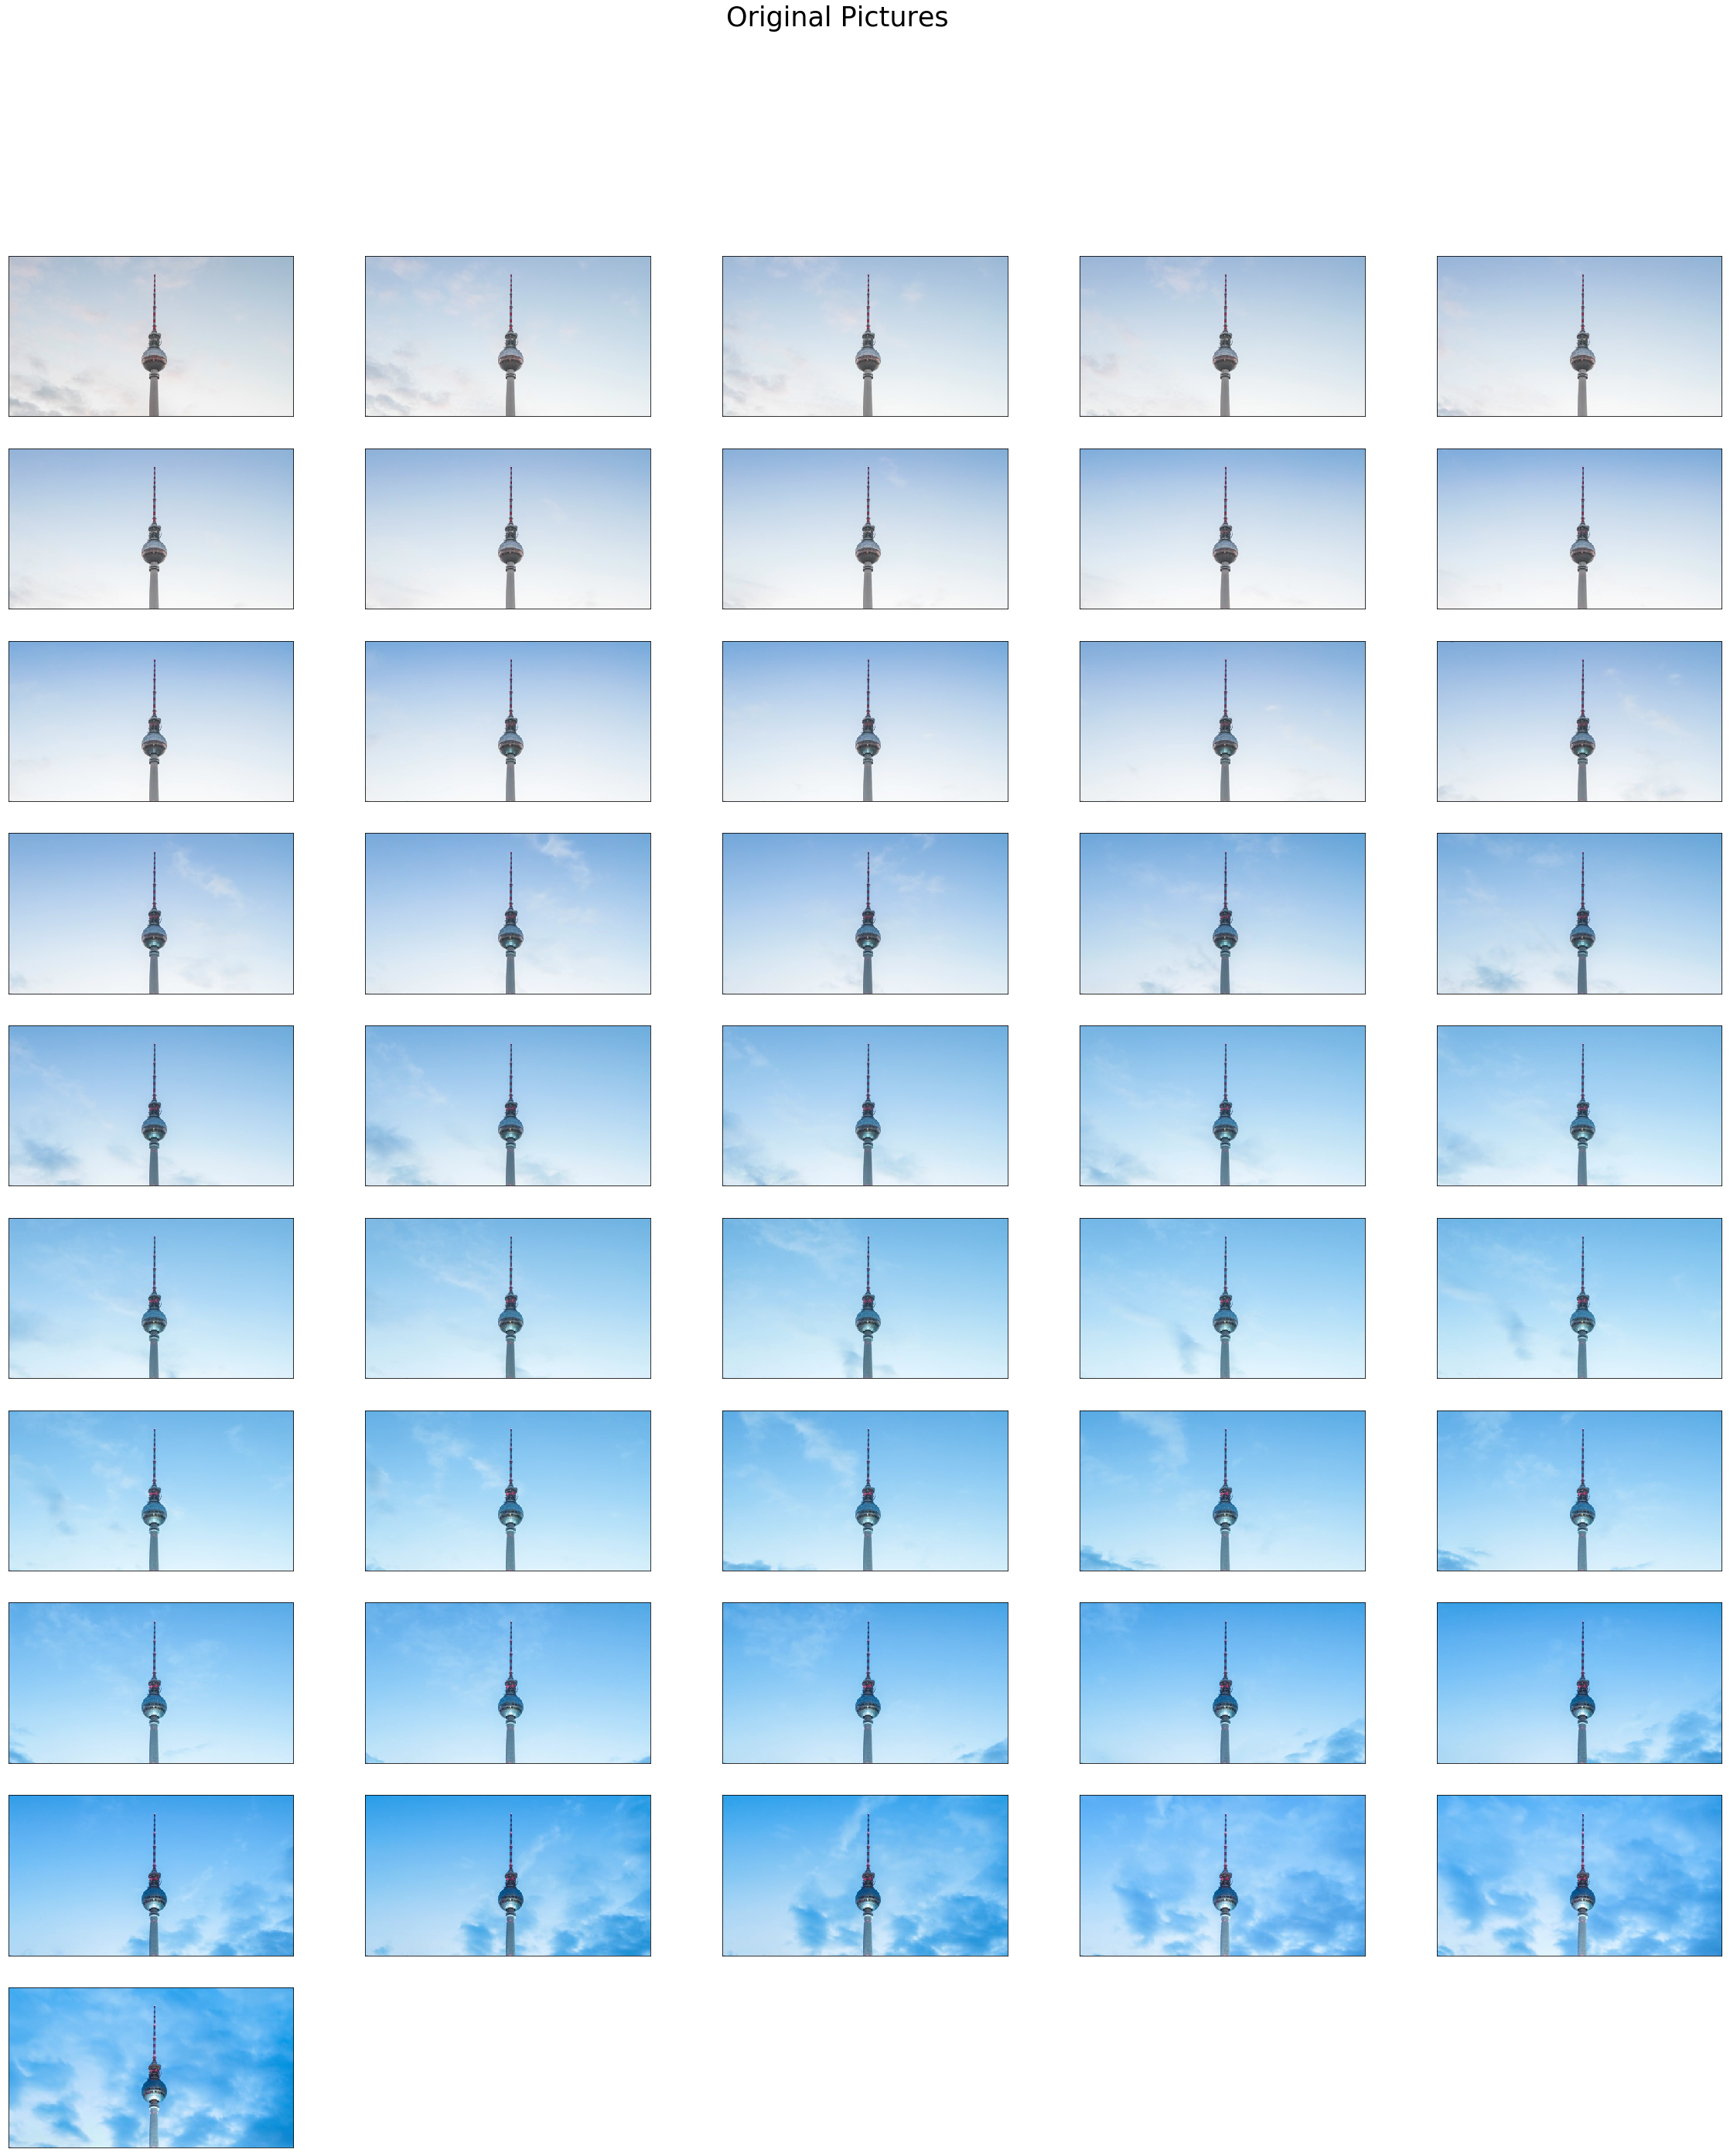

In [11]:
plot_gallery("Original Pictures",images0,10,5,0.5)

In [12]:
# Perform PCA
pca_check = PCA()
pca_check.fit(data);

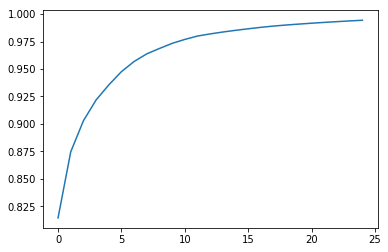

Variance explained by the first two principal components: 0.8746034979479546%.


In [13]:
# Plot explained variace over n_components
plt.plot(np.cumsum(pca_check.explained_variance_ratio_[:25]))
plt.show()
print("Variance explained by the first two principal components: " \
      + str(np.sum(pca_check.explained_variance_ratio_[:2])) + "%.")

In [14]:
# Visualize the principal components
images = []
for i in range(10):
    a = pca_check.components_[i,:]
    images.append(reconstruct(np.interp(a, (a.min(), a.max()), (0, 255))))

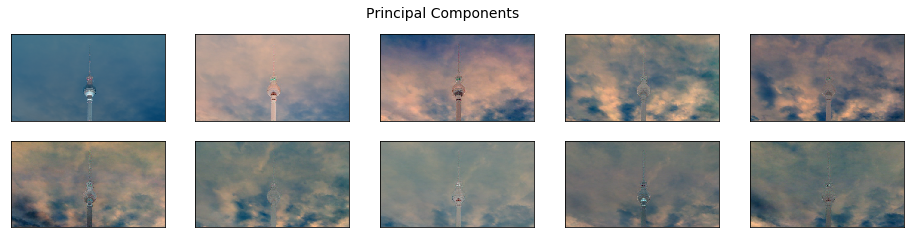

In [15]:
plot_gallery("Principal Components",images,2,5,0.2)

In [16]:
# Using n=2
pca = PCA(n_components=2)
pca.fit(data)
pca_data = pca.transform(data)

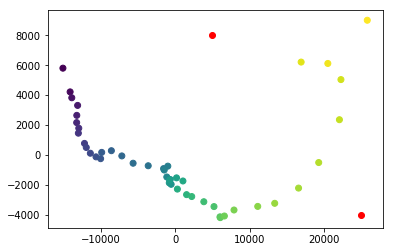

In [20]:
# Plot images by principal components
# Color corresponds to time to verify continuity
plt.scatter(*zip(*pca_data),c=np.arange(46))
# Plotting far points I plot later
plt.scatter([5000,25000],[8000,-4000],c="red")
plt.show()

In [22]:
# Visualizing derivative
images2 = []
# Component 1
for i in range(5):
    images2.append(reconstruct(pca.inverse_transform([-10000+i*10000,0])))
# Component 2
for i in range(5):
    images2.append(reconstruct(pca.inverse_transform([0,-6000+i*3000])))

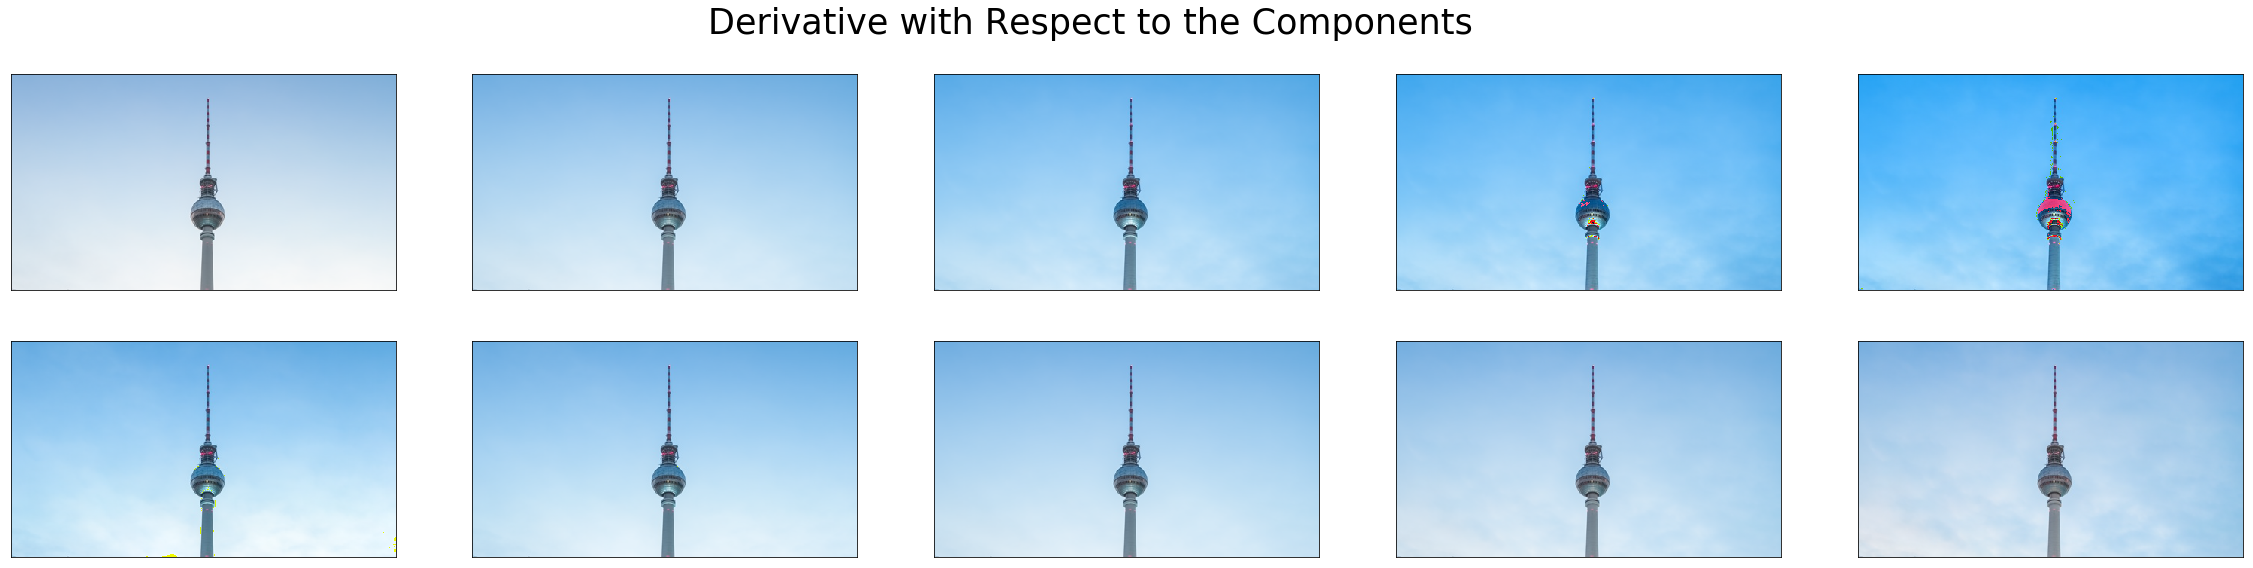

In [24]:
plot_gallery("Derivative with Respect to the Components",images2,2,5,0.5)

In [21]:
# Reconstruct data
recons = pca.inverse_transform(pca_data)

In [28]:
# Reconstruct pictures
images1 = []
for i in range(46):
    images1.append(reconstruct(recons[i]))

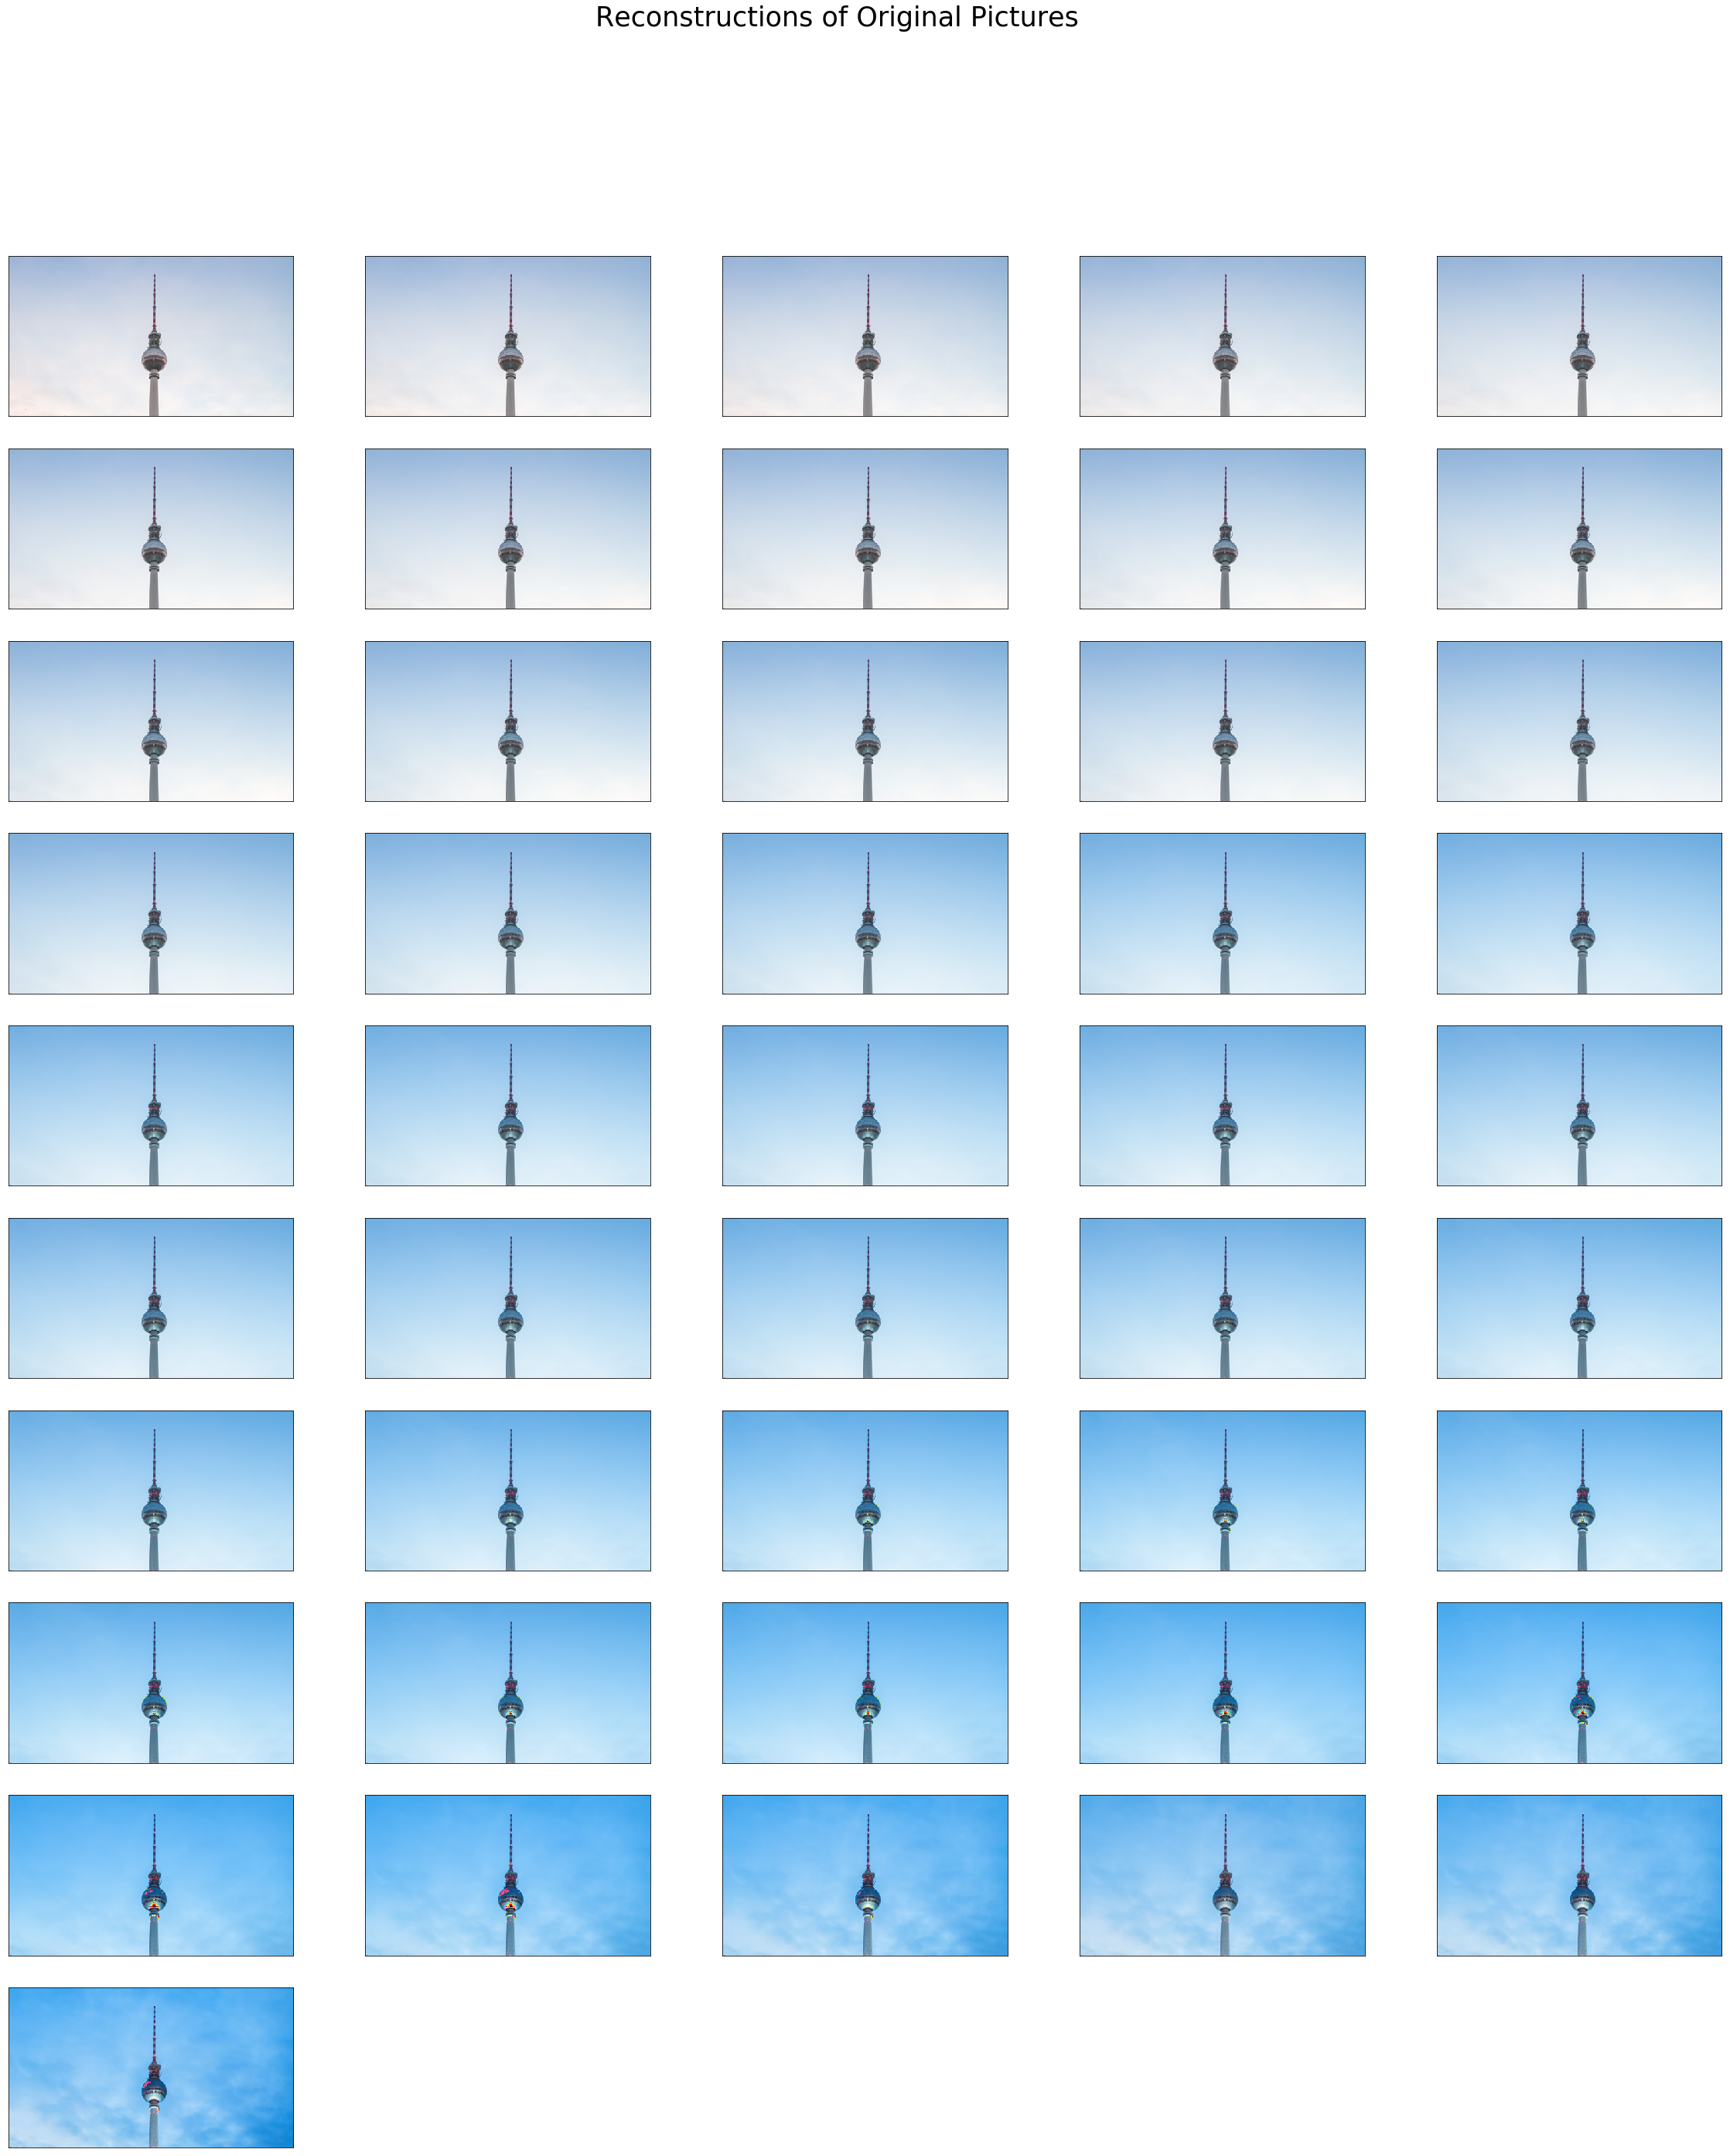

In [29]:
plot_gallery("Reconstructions of Original Pictures",images1,10,5,0.5)

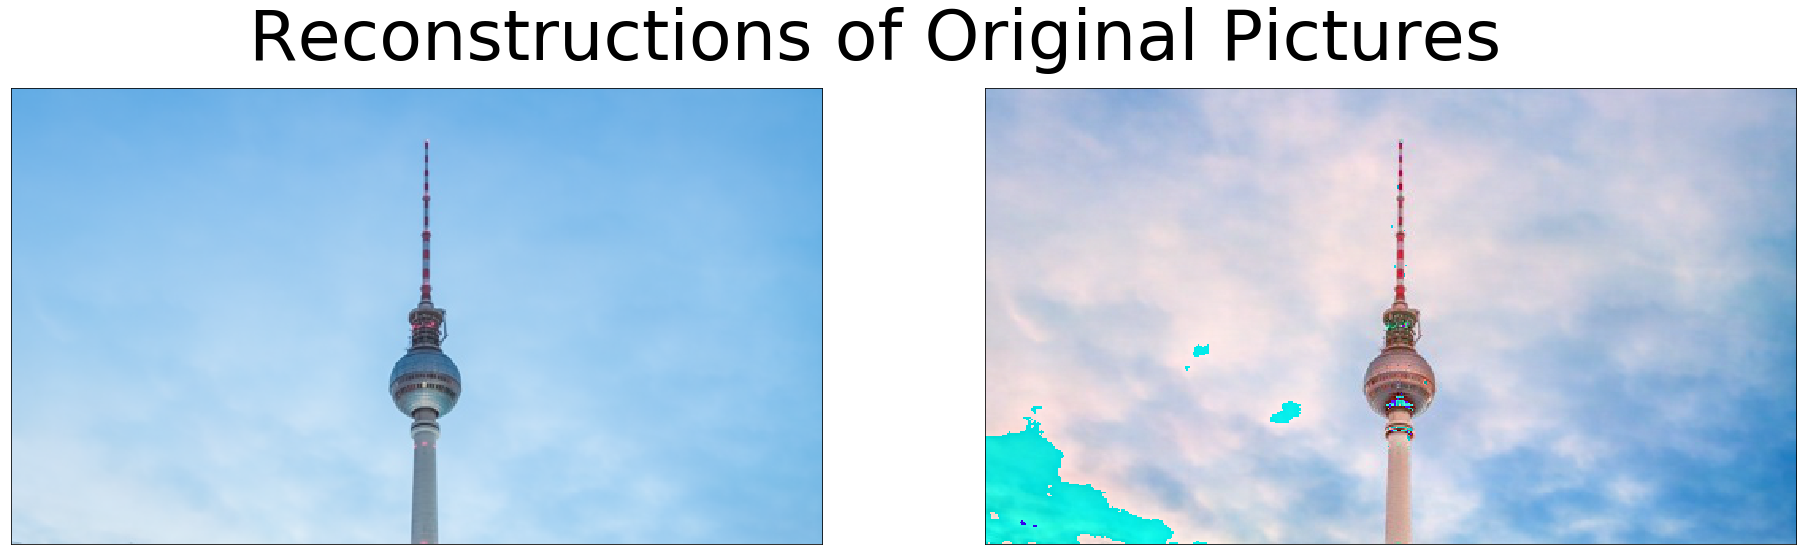

In [30]:
# Visualizing points far from the curve
far1 = reconstruct(pca.inverse_transform([8000,5000]))
far2 = reconstruct(pca.inverse_transform([-4000,25000]))
images = [far1,far2]
plot_gallery("Reconstructions of Original Pictures",images,1,2,1)

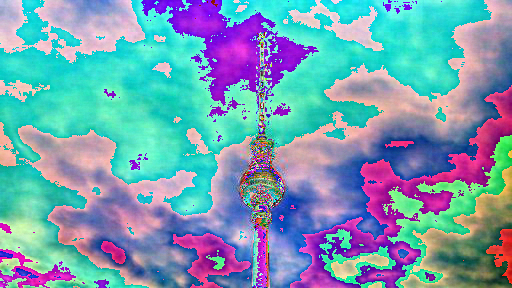

In [31]:
# Visualizing point REALLY far from the curve
# (outside of range)
recon_far = pca.inverse_transform([20000,100000])
reconstruct(recon_far)

In [32]:
# Compare file sizes
uncompressed = reconstruct(data[6])
uncompressed.save('uncompressed.jpg')
compressed = reconstruct(pca_data[6])
compressed.save('reconstructed.jpg')
print("Uncompressed dimensionality: " + str(len(data[6])))
print("Compressed dimensionality: " + str(len(pca_data[6])))
print("Uncompressed size: " + str(stat('uncompressed.jpg').st_size) + " bytes")
print("Reconstructed size: " + str(stat('compressed.jpg').st_size) + " bytes")

Uncompressed dimensionality: 442368
Compressed dimensionality: 2
Uncompressed size: 6310 bytes
Reconstructed size: 2950 bytes
